December 03, 2024

Goal: Figure out how to properly configure `qcec.verify` to setup the benchmark experiments. Let's first load up a large, complex circuit from T-opt benchmarks so that the resulting changes are observable.

In [1]:
cd ..

/home/abhishekabhishek/git/cpsc-513-project


this time, let's consider the `mod_adder_1024.qasm` circuit:

In [2]:
mod_adder_1024_path = "../feynman/benchmarks/qasm/mod_red_21.qasm"

from qiskit import QuantumCircuit
mod_adder_circ = QuantumCircuit.from_qasm_file(mod_adder_1024_path)

# note: do not draw large circuits in notebooks since this causes issues 

**Important note:** We observe that unlike the `qft_4` circuit which had all gates in `Clifford + T`, the adder circuit is represented using `{Toffoli, H}`

Now, let's initialize and setup a `Configuration` object:

In [3]:
from mqt import qcec
from mqt.qcec import Configuration
from mqt.qcec.configuration import augment_config_from_kwargs
config = Configuration()

In [4]:
config_dict = {
    # application
    "alternating_scheme": "proportional",
    "simulation_scheme": "proportional",
    
    # execution
    "run_zx_checker": False,
    "timeout": 60.,
    
    # functionality
    
    # optimizations
    "elide_permutations": False,
    "fuse_single_qubit_gates": False,
    "reconstruct_swaps": False,
    "reorder_operations": False,
    "transform_dynamic_circuit": False,
    
    # simulation
}

In [5]:
# update the configuration with the dictionary
augment_config_from_kwargs(config, config_dict)

In [6]:
config

{
  "application": {
    "alternating": "proportional",
    "simulation": "proportional"
  },
  "execution": {
    "nthreads": 20,
    "parallel": true,
    "run_alternating_checker": true,
    "run_construction_checker": false,
    "run_simulation_checker": true,
    "run_zx_checker": false,
    "timeout": 60.0,
    "tolerance": 2.2737367544323206e-13
  },
  "functionality": {
    "check_partial_equivalence": false,
    "trace_threshold": 1e-08
  },
  "optimizations": {
    "backpropagate_output_permutation": false,
    "elide_permutations": false,
    "fuse_consecutive_single_qubit_gates": false,
    "reconstruct_swaps": false,
    "remove_diagonal_gates_before_measure": false,
    "reorder_operations": false,
    "transform_dynamic_circuit": false
  },
  "parameterized": {
    "additional_instantiations": 0,
    "tolerance": 1e-12
  },
  "simulation": {
    "fidelity_threshold": 1e-08,
    "max_sims": 18,
    "seed": 0,
    "state_type": "computational_basis",
    "store_counterexam

Now, let's attempt to transpile the above circuit and perform equivalence checking

In [4]:
from keys import IBMQ_API
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=IBMQ_API, instance="ibm-q/open/main")
ibm_backend = service.backend("ibm_sherbrooke")
mod_adder_circ_hw = transpile(mod_adder_circ, ibm_backend)

Let's add measurements to both the original and the transpiled circuits:

In [5]:
mod_adder_circ.measure_all()
mod_adder_circ_hw.measure_all()

And now let's verify the equivalence:

In [9]:
qcec.verify(mod_adder_circ, mod_adder_circ_hw, config)

[QCEC] Warning: at least one of the circuits has garbage qubits, but partial equivalence checking is turned off. In order to take into account the garbage qubits, enable partial equivalence checking. Consult the documentation for moreinformation.


<EquivalenceCheckingManager.Results: not_equivalent>

In [ ]:
config = Configuration()
config_dict = {
    # application
    "alternating_scheme": "proportional",
    "simulation_scheme": "proportional",
    
    # execution
    "run_zx_checker": False,
    "timeout": 60.,
    
    # functionality
    "check_partial_equivalence": True,
    
    # optimizations
    "elide_permutations": False,
    "fuse_single_qubit_gates": False,
    "reconstruct_swaps": False,
    "reorder_operations": False,
    "transform_dynamic_circuit": False,
    
    # simulation
}

# update the configuration with the dictionary
augment_config_from_kwargs(config, config_dict)
config

In [7]:
config

{
  "application": {
    "alternating": "proportional",
    "simulation": "proportional"
  },
  "execution": {
    "nthreads": 20,
    "parallel": true,
    "run_alternating_checker": true,
    "run_construction_checker": false,
    "run_simulation_checker": true,
    "run_zx_checker": false,
    "timeout": 60.0,
    "tolerance": 2.2737367544323206e-13
  },
  "functionality": {
    "check_partial_equivalence": true,
    "trace_threshold": 1e-08
  },
  "optimizations": {
    "backpropagate_output_permutation": false,
    "elide_permutations": false,
    "fuse_consecutive_single_qubit_gates": false,
    "reconstruct_swaps": false,
    "remove_diagonal_gates_before_measure": false,
    "reorder_operations": false,
    "transform_dynamic_circuit": false
  },
  "parameterized": {
    "additional_instantiations": 0,
    "tolerance": 1e-12
  },
  "simulation": {
    "fidelity_threshold": 1e-08,
    "max_sims": 18,
    "seed": 0,
    "state_type": "computational_basis",
    "store_counterexamp

In [8]:
qcec.verify(mod_adder_circ, mod_adder_circ_hw, config)

<EquivalenceCheckingManager.Results: not_equivalent>

Why tf does this return False? Does this have to do with the extra qubits on the backend? Or is it because we're compiling to an actual backend and not a fake provider? let's find out. since there's no fake 9 qubit backend, let's try the above for a 7 qubit circuit:

In [14]:
config = Configuration()
config_dict = {
    # application
    "alternating_scheme": "proportional",
    "simulation_scheme": "proportional",
    
    # execution
    "run_zx_checker": False,
    "timeout": 60.,
    
    # functionality
    "check_partial_equivalence": True,
    
    # optimizations
    "elide_permutations": False,
    "fuse_single_qubit_gates": False,
    "reconstruct_swaps": False,
    "reorder_operations": False,
    "transform_dynamic_circuit": False,
    
    # simulation
}

# update the configuration with the dictionary
augment_config_from_kwargs(config, config_dict)
print(config)

{
  "application": {
    "alternating": "proportional",
    "simulation": "proportional"
  },
  "execution": {
    "nthreads": 20,
    "parallel": true,
    "run_alternating_checker": true,
    "run_construction_checker": false,
    "run_simulation_checker": true,
    "run_zx_checker": false,
    "timeout": 60.0,
    "tolerance": 2.2737367544323206e-13
  },
  "functionality": {
    "check_partial_equivalence": true,
    "trace_threshold": 1e-08
  },
  "optimizations": {
    "backpropagate_output_permutation": false,
    "elide_permutations": false,
    "fuse_consecutive_single_qubit_gates": false,
    "reconstruct_swaps": false,
    "remove_diagonal_gates_before_measure": false,
    "reorder_operations": false,
    "transform_dynamic_circuit": false
  },
  "parameterized": {
    "additional_instantiations": 0,
    "tolerance": 1e-12
  },
  "simulation": {
    "fidelity_threshold": 1e-08,
    "max_sims": 18,
    "seed": 0,
    "state_type": "computational_basis",
    "store_counterexamp

In [15]:
circ_path = "../feynman/benchmarks/qasm/tof_4.qasm"
circ = QuantumCircuit.from_qasm_file(circ_path)
circ_hw = transpile(circ, ibm_backend)

circ.measure_all()
circ_hw.measure_all()

qcec.verify(circ, circ_hw, config)

<EquivalenceCheckingManager.Results: not_equivalent>

Hmm. Adding `measure_all()` to the original and transpiled circuit is also potentially bad since we don't care about the measurement and state of the other 120 qubits not being used in the original circuit. let's now try the above with a fake backend.

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeOslo

In [25]:
circ_path = "../feynman/benchmarks/qasm/tof_4.qasm"
circ = QuantumCircuit.from_qasm_file(circ_path)
circ_hw = transpile(circ, backend=FakeOslo())

qcec.verify(circ, circ_hw, config)

<EquivalenceCheckingManager.Results: not_equivalent>

Damn. This still returns `not_equivalent` for two circuits that should clearly be equivalent. Did we mess-up something with the configuration settings? How about we don't pass config to `qcec.verify`?

In [26]:
qcec.verify(circ, circ_hw)

<EquivalenceCheckingManager.Results: not_equivalent>

Nope, it doesn't make a difference. So, what's wrong here? Let's try visualizing the circuits:

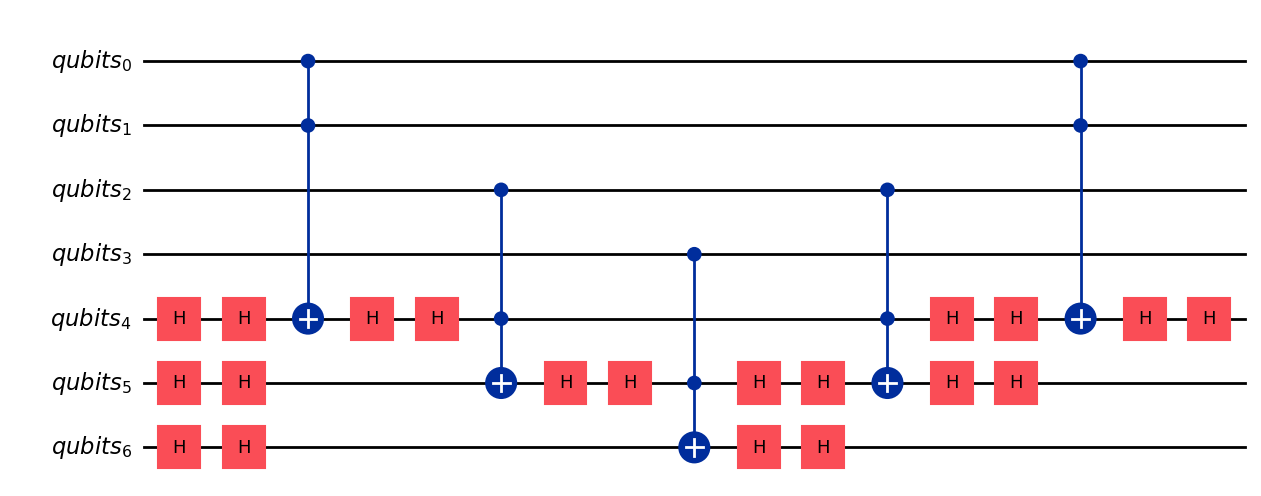

In [27]:
circ.draw(output="mpl")

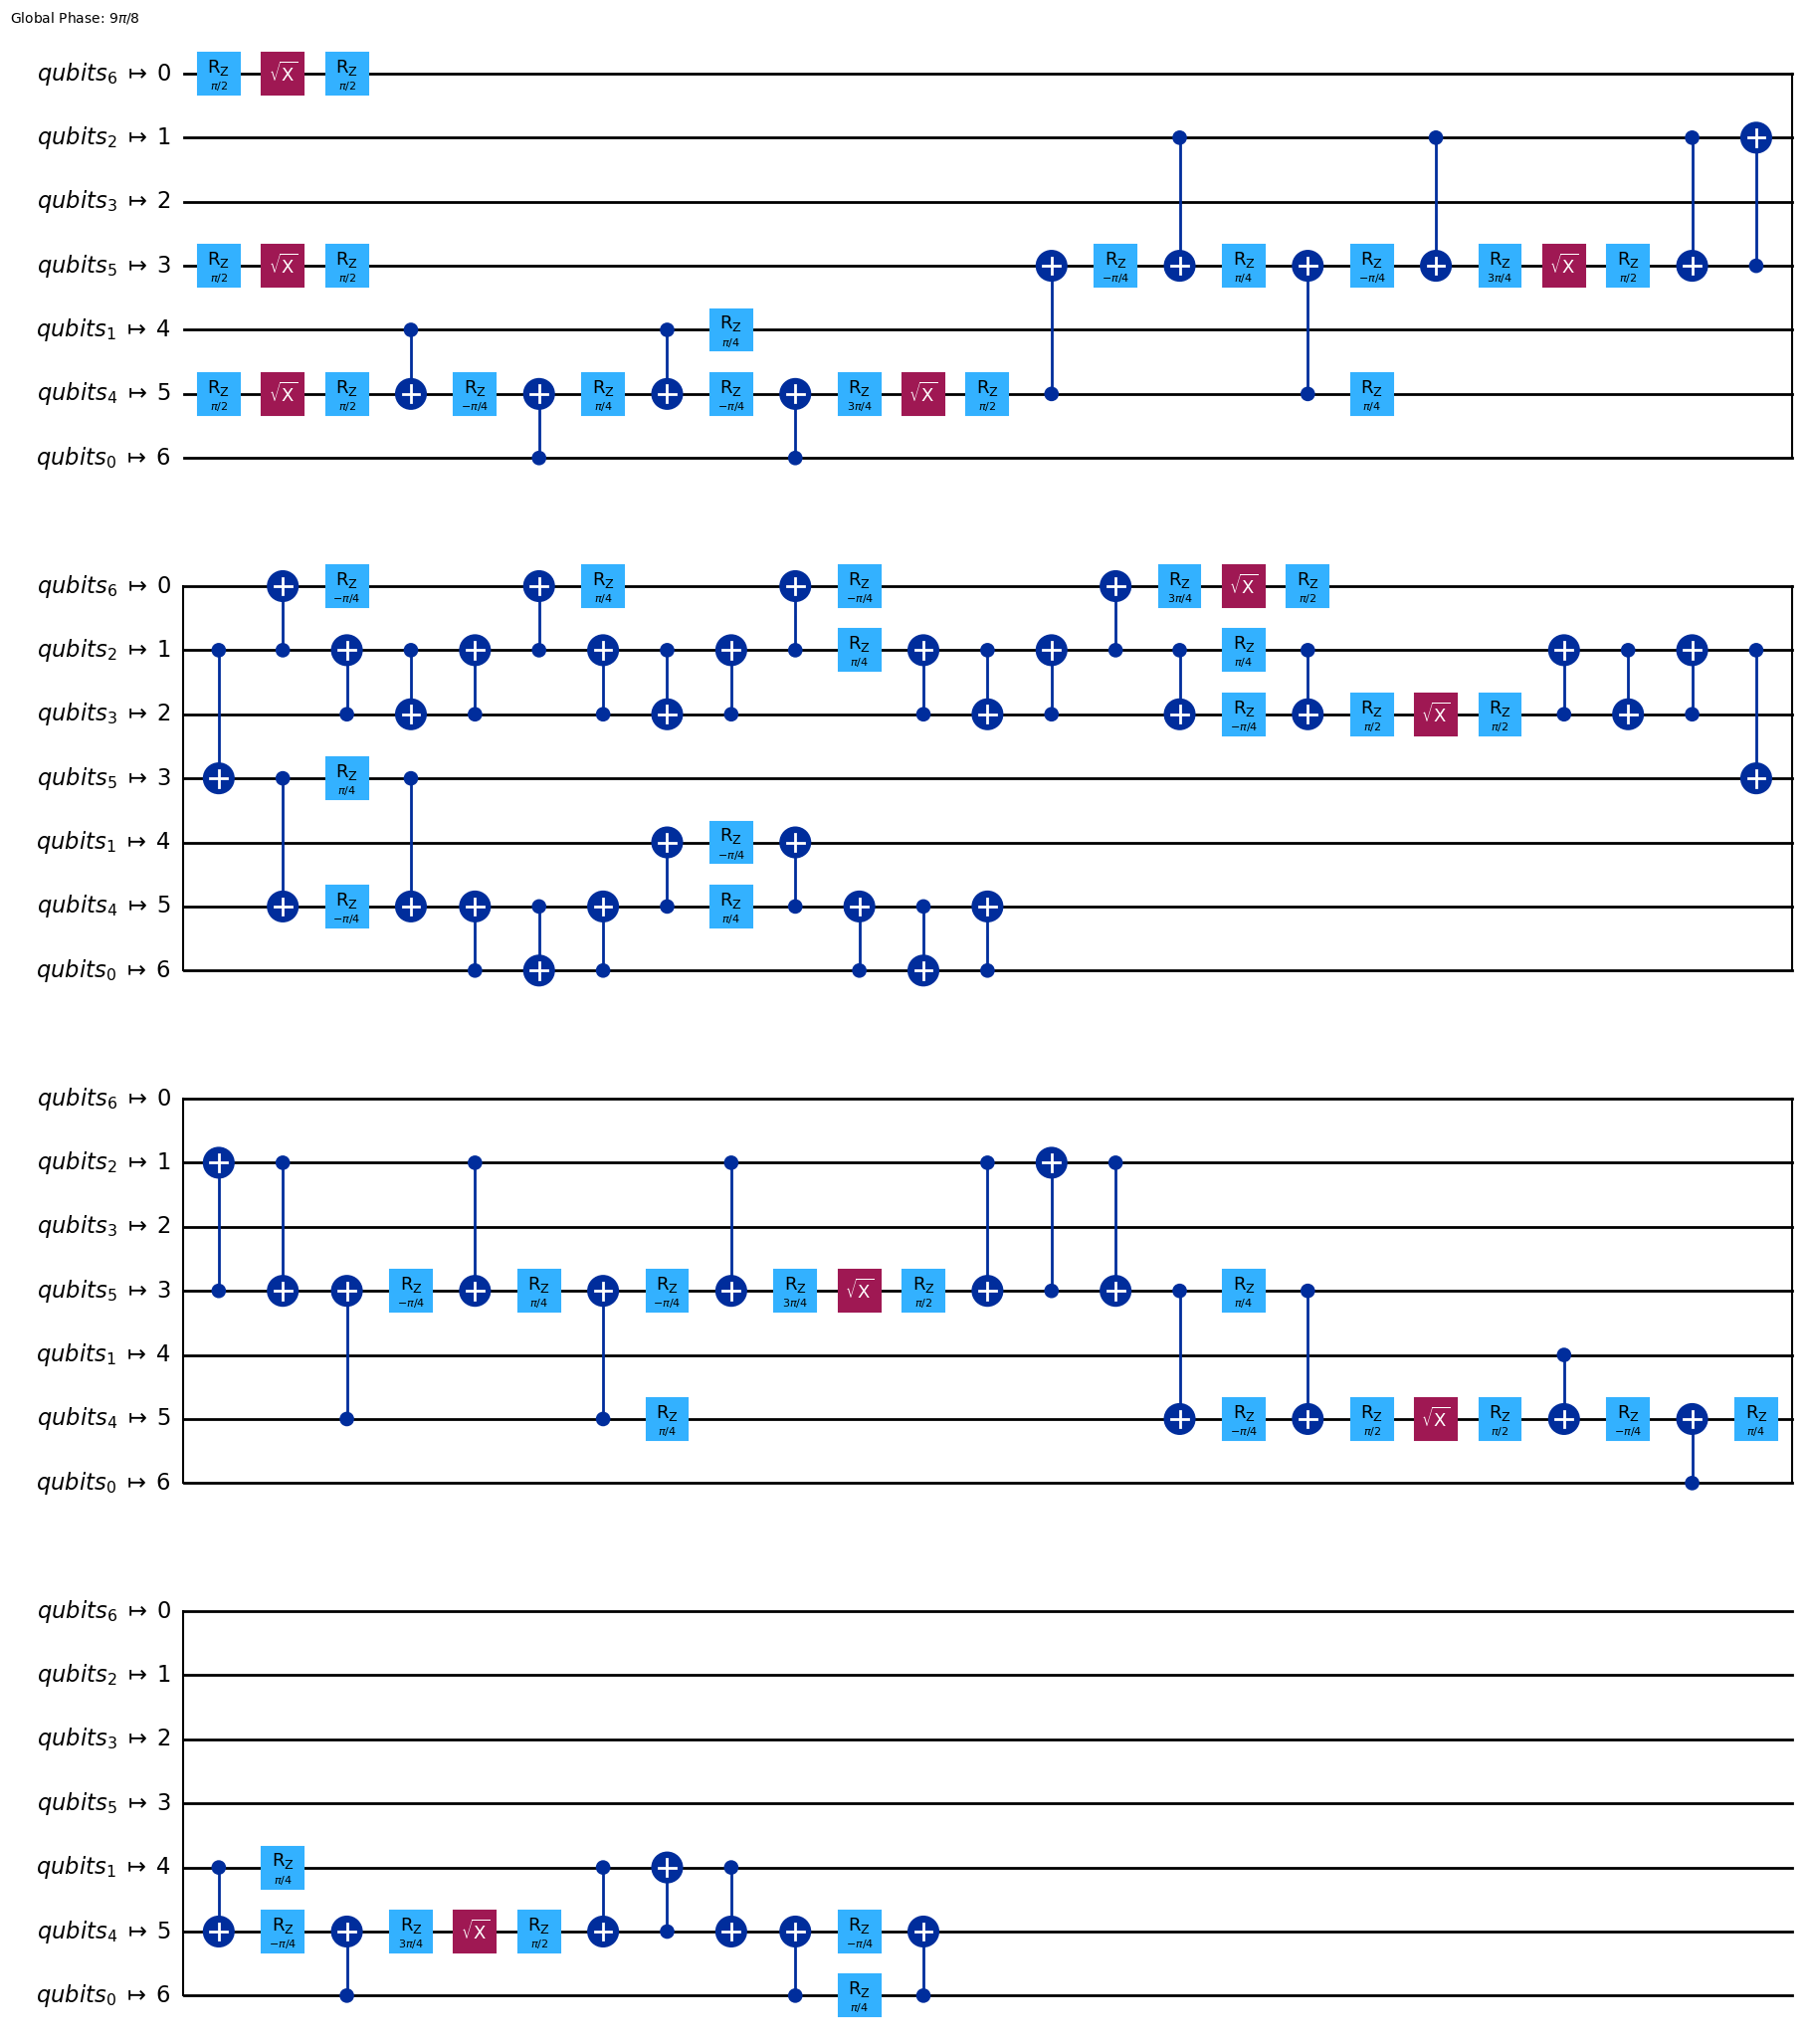

In [28]:
circ_hw.draw(output="mpl")